In [1]:
import pandas as pd 
import numpy as np
import inshallah as ins
from sklearn.impute import KNNImputer 

ya allah


In [2]:
#Load data
train = pd.read_csv("../CSV/big_files/ais_train.csv", sep="|")
vessels = pd.read_csv("../CSV/vessels.csv", sep="|")

test = pd.read_csv("../CSV/ais_test.csv")

vessels.head()

#Helper functions
def evaluate(model: str, y_pred):
    mse_latitude = mean_squared_error(y_test[0], y_pred["delta_lat"])
    mse_longitude = mean_squared_error(y_test[1], y_pred["delta_lon"])

    print(f"---- {model} Metrics ----")
    print(f"Mean Squared Error (Latitude): {mse_latitude:.4f}")
    print(f"Mean Squared Error (Longitude): {mse_longitude:.4f}")

def normalize_lat_lon(lat, lon):
    """
    Normalizes extreme latitude and longitude values, ensuring:
    - Latitude is constrained between [-90, 90] with appropriate longitude shifts.
    - Longitude is wrapped to be within [-180, 180].
    """
    
    # Handle extreme latitude values
    while lat > 90 or lat < -90:
        if lat > 90:
            lat = 180 - lat
            lon += 180
        elif lat < -90:
            lat = -180 - lat
            lon += 180
    
    # Normalize longitude using modulo to bring it within [-180, 180]
    lon = ((lon + 180) % 360) - 180
    
    return lat, lon

lat = -270.95379638671875
lon = -494.88262939453125

print(normalize_lat_lon(lat, lon))


(89.04620361328125, -134.88262939453125)


In [3]:
#Impute missing values from vesselData and standardize numeric values
#Imputation
vesselData = vessels.copy()
imputer = KNNImputer(n_neighbors=15)

non_numeric = ["vesselId", "shippingLineId", "homePort"]
non = vesselData[non_numeric]
vesselData.drop(columns=non_numeric, inplace=True)

cols, ind = vesselData.columns, vesselData.index

vesselData = pd.DataFrame(imputer.fit_transform(vesselData), columns=cols, index=ind)

#Standardization
mean, std = vesselData.mean(), vesselData.std()

vesselData = (vesselData - mean) / std

for i in non_numeric:
    vesselData[i] = non[i]

vesselData.head()

,CEU,DWT,GT,NT,vesselType,breadth,depth,draft,enginePower,freshWater,fuel,length,maxHeight,maxSpeed,maxWidth,rampCapacity,yearBuilt,vesselId,shippingLineId,homePort
0,0.683152,0.312343,0.457839,0.113825,0.455323,0.252210,0.849158,0.0,-0.939765,1.309901,0.157684,0.160713,-0.464834,-4.025736,1.957438,0.145527,-1.228745,61e9f38eb937134a3c4bfd8b,61a8e672f9cba188601e84ab,OSLO
1,-0.047778,-0.729041,-0.269906,-0.795205,0.455323,-0.029880,0.258777,0.0,1.019299,-0.289941,-0.318174,-0.553878,0.054326,1.390543,-0.041630,-0.661098,-0.239908,61e9f38eb937134a3c4bfd8d,61ec94f1a8cafc0e93f0e92a,MONROVIA
2,-0.002952,-0.642914,-0.269906,-0.768096,0.455323,-0.029880,0.303612,0.0,1.019299,-0.306205,-0.185916,-0.553878,0.054326,1.450613,-0.041630,-0.661098,0.419317,61e9f38eb937134a3c4bfd8f,61e213d5d612676a0f0fb755,SAINT JOHN'S
3,-0.368875,-0.698181,-0.725389,-0.811794,0.455323,-0.876149,-0.559052,0.0,0.583952,-1.101545,-0.672795,-1.184400,-0.637887,-0.191291,-0.455851,-0.661098,0.584123,61e9f38eb937134a3c4bfd91,61be24574ea00ae59d0fe388,NaN
4,1.117685,0.294977,1.489321,1.815871,0.455323,1.719076,0.863885,0.0,0.870509,-0.081192,1.021043,0.201907,1.646414,0.389382,2.011467,1.960433,1.737766,61e9f390b937134a3c4bfd93,61a8e673f9cba188601e84ae,Panama


In [4]:
#Cleaning train data, standardize and merge with imputed vessels
data = train.copy()
data = pd.merge(data, vesselData, how="left")

data = ins.cleanUp(data, n=20, time=True)
""" 
mean = data[["sog", "dist_from_prev", "speed_from_prev", "time_at_sea"]].mean()
std = data[["sog", "dist_from_prev", "speed_from_prev", "time_at_sea"]].std()
data[["sog", "dist_from_prev", "speed_from_prev", "time_at_sea"]] = (data[["sog", "dist_from_prev", "speed_from_prev", "time_at_sea"]] - mean) / std
 """
#Set vesselId, navstat and shippinglineId as categoricals
data["vesselId"] = pd.Categorical(data["vesselId"], categories=data["vesselId"].unique())
data["shippingLineId"] = pd.Categorical(data["shippingLineId"], categories=data["shippingLineId"].unique())
data["navstat"] = pd.Categorical(data["navstat"], categories=data["navstat"].unique())
data["navstat_lag_1"] = pd.Categorical(data["navstat_lag_1"], categories=data["navstat"].unique())
data["navstat_lag_2"] = pd.Categorical(data["navstat_lag_2"], categories=data["navstat"].unique())

#Fuck homeport
data.drop(columns=["homePort"], inplace=True)

#Lat/lon fix
for i,row in data.iterrows():
    lat, lon = normalize_lat_lon(row["latitude"], row["longitude"])
    
    data.at[i, "latitude"] = lat
    data.at[i, "longitude"] = lon

#Volume
# data["volume"] = data["length"] * data["depth"] * data["breadth"]

data.head()

,time,cog,sog,rot,heading,navstat,etaRaw,latitude,longitude,vesselId,...,delta_lon_lag_5,speed_lag_1,speed_lag_2,dist_lag_1,dist_lag_2,navstat_lag_1,navstat_lag_2,month,day,hour
31706,7954.0,4.382522,0.0,5,4.380776,5,12-30 20:00,-23.95986,-46.29805,61e9f3c4b937134a3c4bfec3,...,-0.00002,0.0,0.0,0.005208,0.002036,5,5,1,0,2
23915,8196.0,2.876303,0.1,0,4.293510,5,12-25 15:00,40.72223,29.48063,61e9f3c6b937134a3c4bfed5,...,0.00000,0.0,0.0,0.001110,0.002221,5,5,1,0,2
6673,8261.0,2.153736,0.0,128,3.071779,5,12-16 01:00,40.71466,29.46602,61e9f46bb937134a3c4c02b3,...,-0.00001,0.0,0.0,0.000845,0.000845,5,5,1,0,2
11544,8270.0,2.638938,0.0,0,3.630285,5,12-31 18:30,-19.25027,146.83509,61e9f3bfb937134a3c4bfe9f,...,0.00000,0.0,0.0,0.003931,0.004580,5,5,1,0,2
16641,8274.0,0.317650,8.9,5,1.239184,0,12-31 23:59,51.60632,2.71856,61e9f3adb937134a3c4bfe39,...,-0.03299,0.0,0.0,5.473558,4.938251,0,0,1,0,2


In [5]:
#more imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from geopy.distance import distance

In [29]:
#Train-test splitting
vessel = "61e9f3adb937134a3c4bfe39"

FEATURES = ["vesselId", "time"]

for i in range(1,6):
    FEATURES.append(f"delta_lat_lag_{i}")
    FEATURES.append(f"delta_lon_lag_{i}")

TARGETS = ["delta_lat", "delta_lon"]

X, y = data[FEATURES + ["latitude", "longitude"]].reset_index(drop=True), data[TARGETS].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

X_train_hot = pd.get_dummies(X_train, ["vesselId"])
X_test_hot = pd.get_dummies(X_test, ["vesselId"])

last_lat = X_train[X_train["vesselId"] == vessel].iloc[-1]["latitude"]
last_lon = X_train[X_train["vesselId"] == vessel].iloc[-1]["longitude"]

X_train_hot.drop(columns=["latitude", "longitude"], inplace=True)
X_test_hot.drop(columns=["latitude", "longitude"], inplace=True)

X_test.reset_index(drop=True, inplace=True)
X_test.head()

,vesselId,time,delta_lat_lag_1,delta_lon_lag_1,delta_lat_lag_2,delta_lon_lag_2,delta_lat_lag_3,delta_lon_lag_3,delta_lat_lag_4,delta_lon_lag_4,delta_lat_lag_5,delta_lon_lag_5,latitude,longitude
0,61e9f3adb937134a3c4bfe39,10515408.0,0.00000,0.00001,0.00000,-0.00001,0.0000,0.00000,0.00000,0.00000,0.00000,-0.00001,51.25999,4.23852
1,61e9f41bb937134a3c4c0087,10515499.0,0.00817,0.05017,-0.00629,0.01480,-0.0231,0.01391,-0.01942,0.00651,-0.00002,-0.00001,1.24369,104.01016
2,61e9f468b937134a3c4c028f,10516603.0,0.00000,-0.00002,0.00000,0.00000,0.0000,0.00000,0.00001,0.00000,0.00000,0.00002,24.27432,-110.32730
3,61e9f3adb937134a3c4bfe39,10516640.0,0.00000,0.00000,0.00000,0.00001,0.0000,-0.00001,0.00000,0.00000,0.00000,0.00000,51.25998,4.23852
4,61e9f3c9b937134a3c4bfef7,10516652.0,-0.00001,-0.00002,0.00001,0.00001,0.0000,-0.00003,-0.00002,0.00002,0.00000,0.00001,39.43817,-0.30533


In [30]:
# XGBOOST
model = XGBRegressor(n_estimators=5000, early_stopping_rounds=50)
model.fit(X_train_hot, y_train, verbose=100, eval_set=[(X_train_hot, y_train)])

y_pred = pd.DataFrame(model.predict(X_test_hot))

print("XGboost, early_stop=50, 3000 est.")
print(f"Total MSE: {mean_squared_error(y_test, y_pred)}")

# FEATURES = ["vesselId", "time", "speed_from_prev", "dist_from_prev", "NT", "length"] - 14.5 MSE
# est=5000, early_stop=50, eval_set=[(X_train, y_train)]


[0]	validation_0-rmse:3.50605
[100]	validation_0-rmse:0.40783
[200]	validation_0-rmse:0.19642
[300]	validation_0-rmse:0.11767
[400]	validation_0-rmse:0.07896
[500]	validation_0-rmse:0.05644
[600]	validation_0-rmse:0.04160
[700]	validation_0-rmse:0.03213
[800]	validation_0-rmse:0.02556
[900]	validation_0-rmse:0.02047
[1000]	validation_0-rmse:0.01648
[1100]	validation_0-rmse:0.01357
[1200]	validation_0-rmse:0.01095
[1300]	validation_0-rmse:0.00905
[1400]	validation_0-rmse:0.00753
[1500]	validation_0-rmse:0.00635
[1600]	validation_0-rmse:0.00546
[1700]	validation_0-rmse:0.00466
[1800]	validation_0-rmse:0.00399
[1900]	validation_0-rmse:0.00359
[2000]	validation_0-rmse:0.00329
[2078]	validation_0-rmse:0.00323
XGboost, early_stop=50, 3000 est.
Total MSE: 49.47276467640356


In [31]:
#XGBOOST - AR
stats = {}

test = X_test.copy()
test = test[["time", "vesselId"]]

test.sort_values(["vesselId", "time"], inplace=True)
test.reset_index(inplace=True, drop=True)

test["first_row"] = test["vesselId"].ne(test["vesselId"].shift())

for i in test["vesselId"].unique():
    qwe = X_train[X_train["vesselId"] == i].iloc[-1]
    stats[i] = {}

    # dist = qwe["dist_from_prev"]
    # speed = qwe["speed_from_prev"]
    # stats[i] = {"dist_from_prev":dist, "speed_from_prev":speed}

    for j in range(1,6):
        lat, lon = qwe[f"delta_lat_lag_{j}"], qwe[f"delta_lon_lag_{j}"]

        stats[i][f"delta_lat_lag_{j}"] = lat
        stats[i][f"delta_lon_lag_{j}"] = lon

for i,row in test.iterrows():
    if row["first_row"]:
        # test.at[i, "dist_from_prev"] = stats[row["vesselId"]]["dist_from_prev"]
        # test.at[i, "speed_from_prev"] = stats[row["vesselId"]]["speed_from_prev"]

        for j in range(1,6):
            test.at[i, f"delta_lat_lag_{j}"] = stats[row["vesselId"]][f"delta_lat_lag_{j}"]
            test.at[i, f"delta_lon_lag_{j}"] = stats[row["vesselId"]][f"delta_lon_lag_{j}"]

test.drop(columns=["first_row"], inplace=True)
X_train_2 = X_train.copy()
X_train_2 = X_train_2[FEATURES]


test.head()


,time,vesselId,delta_lat_lag_1,delta_lon_lag_1,delta_lat_lag_2,delta_lon_lag_2,delta_lat_lag_3,delta_lon_lag_3,delta_lat_lag_4,delta_lon_lag_4,delta_lat_lag_5,delta_lon_lag_5
0,10833199.0,61e9f3c4b937134a3c4bfec3,0.26418,0.16874,0.06252,0.0349,0.07811,0.08681,0.07094,0.08702,0.08334,0.07443
1,10834578.0,61e9f3c4b937134a3c4bfec3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10835778.0,61e9f3c4b937134a3c4bfec3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10837019.0,61e9f3c4b937134a3c4bfec3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10837898.0,61e9f3c4b937134a3c4bfec3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
X_train_2_hot = pd.get_dummies(X_train_2, "vesselId", drop_first=False).to_numpy()
testhot = pd.get_dummies(test, "vesselId", drop_first=False)

ar = XGBRegressor(n_estimators=3000, early_stopping_rounds=10)
ar.fit(X_train_2_hot, y_train.to_numpy(), verbose=0, eval_set=[(X_train_2_hot, y_train.to_numpy())])

def predict(boat: pd.DataFrame) -> pd.DataFrame:
    boat = boat.to_numpy()
    next_input = boat[0].reshape(1,-1)

    pred = ar.predict(next_input)

    for i in range(len(boat)-1):
        pred = ar.predict(next_input)

        # Update next rows lats/lons
        boat[i+1][1], boat[i+1][2] = pred[0][0], pred[0][1]
        
        for j in range(1,9):
            boat[i+1][2+j] = boat[i][j]

        #Update next rows dist/speed
        # dist = distance((boat[i][3], boat[i][4]), (boat[i+1][3], boat[i+1][4])).km
        # speed = dist / ((boat[i+1][0] - boat[i][0]) / 3600)

        # boat[i+1][1] = dist
        # boat[i+1][2] = speed

        #Update next_input
        next_input = boat[i+1].reshape(1,-1)

    df = pd.DataFrame(boat)
    cols = ["time"]
    for j in range(1,6):
        cols.append(f"delta_lat_lag_{j}")
        cols.append(f"delta_lon_lag_{j}")

    df.columns = cols
    
    return df

predictions = []

for i in test["vesselId"].unique():
    boat = testhot[testhot["vesselId_" + i]]
    
    ninja = predict(boat)
    ninja["vesselId"] = i

    for _,row in ninja.iterrows():
        predictions.append(row.to_dict())

brosjan = pd.DataFrame(predictions)
brosjan.head()

ValueError: Length mismatch: Expected axis has 27 elements, new values have 11 elements

In [47]:
boat = test[test["vesselId"] == vessel]

boat = pd.get_dummies(boat, "vesselId")
print(boat.head())

boat = boat.to_numpy()
next_input = boat[0].reshape(1,-1)

for i in range(len(boat)-1):
    pred = ar.predict(next_input)

    boat[i+1][1], boat[i+1][2] = pred[0][0], pred[0][1]
            
    for j in range(1,9):
        boat[i+1][2+j] = boat[i][j]

    next_input = boat[i+1].reshape(1,-1)

boat = pd.DataFrame(boat)
print(pred)
boat.head()

           time  delta_lat_lag_1  delta_lon_lag_1  delta_lat_lag_2  \
338  10515408.0              0.0         -0.00001              0.0   
339  10516640.0              NaN              NaN              NaN   
340  10517903.0              NaN              NaN              NaN   
341  10518623.0              NaN              NaN              NaN   
342  10520061.0              NaN              NaN              NaN   

     delta_lon_lag_2  delta_lat_lag_3  delta_lon_lag_3  delta_lat_lag_4  \
338              0.0              0.0              0.0              0.0   
339              NaN              NaN              NaN              NaN   
340              NaN              NaN              NaN              NaN   
341              NaN              NaN              NaN              NaN   
342              NaN              NaN              NaN              NaN   

     delta_lon_lag_4  delta_lat_lag_5  ...  vesselId_61e9f3aab937134a3c4bfe0b  \
338         -0.00001          0.00001  ...     

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,10515408.0,0.0,-0.00001,0.0,0.0,0.0,0.0,0.0,-0.00001,0.00001,...,False,False,False,False,False,False,False,False,False,False
1,10516640.0,0.000504,-0.000197,0.0,-0.00001,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,10517903.0,0.005235,-0.020257,0.000504,-0.000197,0.0,-0.00001,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,10518623.0,0.067181,0.014916,0.005235,-0.020257,0.000504,-0.000197,0.0,-0.00001,0.0,...,False,False,False,False,False,False,False,False,False,False
4,10520061.0,0.188327,-0.120534,0.067181,0.014916,0.005235,-0.020257,0.000504,-0.000197,0.0,...,False,False,False,False,False,False,False,False,False,False


In [289]:
#Visualize
df = df[["time", "latitude", "longitude"]]
df["vesselId"] = vessel

trained = X_train[X_train["vesselId"] == vessel][["vesselId", "time", "latitude", "longitude"]]
trained.head()

fig = (
    ins.visualize_vessel_movements(trained)
)
fig.show()

fig = (
    ins.visualize_vessel_movements(df)
)
fig.show()

In [124]:
#Reconstruct boat
trained = X_train[X_train["vesselId"] == vessel][["vesselId", "time", "latitude", "longitude"]]

predicted = pd.DataFrame(y_pred).copy()
predicted["vesselId"] = X_test["vesselId"]
predicted["time"] = X_test["time"]

predicted = predicted[predicted["vesselId"] == vessel]

predicted["latitude"] = y_pred[0].cumsum() + last_lat
predicted["longitude"] = y_pred[1].cumsum() + last_lon

predicted = predicted[["vesselId", "time", "latitude", "longitude"]]

#Lat/lon fix
for i,row in predicted.iterrows():
    lat, lon = normalize_lat_lon(row["latitude"], row["longitude"])
    
    predicted.at[i, "latitude"] = lat
    predicted.at[i, "longitude"] = lon

predicted.head()

#Actual path
actual = y_test.copy()
actual.reset_index(inplace=True, drop=True)

actual["vesselId"] = X_test["vesselId"]
actual["time"] = X_test["time"]

actual = actual[actual["vesselId"] == vessel]

actual["latitude"] = actual["delta_lat"].cumsum() + last_lat
actual["longitude"] = actual["delta_lon"].cumsum() + last_lon

actual = actual[["vesselId", "time", "latitude", "longitude"]]

#Lat/lon fix
for i,row in actual.iterrows():
    lat, lon = normalize_lat_lon(row["latitude"], row["longitude"])
    
    actual.at[i, "latitude"] = lat
    actual.at[i, "longitude"] = lon

actual.head()


,vesselId,time,latitude,longitude
3,61e9f465b937134a3c4c0269,10513036.0,59.60682,23.15745
16,61e9f465b937134a3c4c0269,10514278.0,59.56064,22.91975
26,61e9f465b937134a3c4c0269,10515496.0,59.51290,22.68909
36,61e9f465b937134a3c4c0269,10516696.0,59.45669,22.47430
40,61e9f465b937134a3c4c0269,10516852.0,59.44681,22.44929


In [125]:
fig = (
    ins.visualize_vessel_movements(trained)
)
fig.show()

fig = (
    ins.visualize_vessel_movements(predicted)
)
fig.show()

fig = (
    ins.visualize_vessel_movements(actual)
)
fig.show()

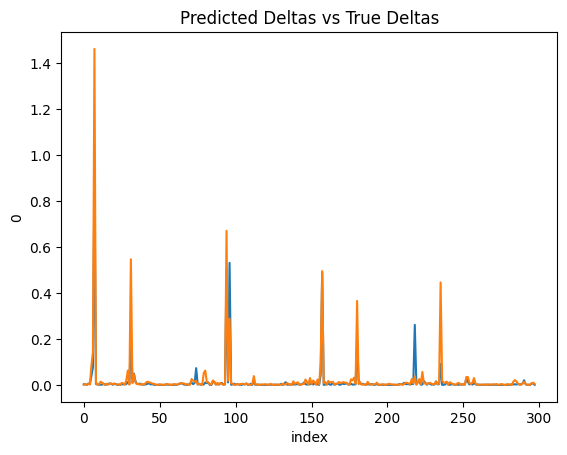

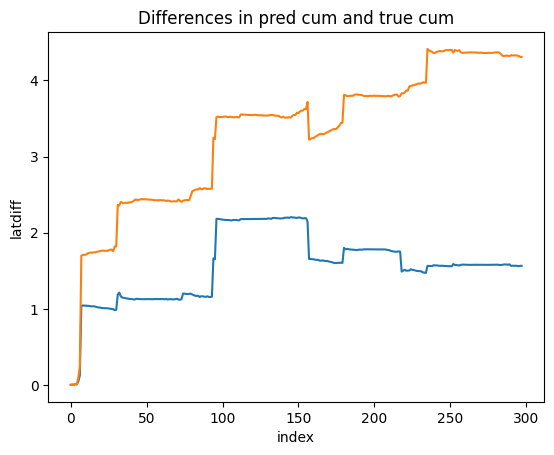

In [107]:
bruh = y_pred.copy()
bruh["vesselId"] = X_test["vesselId"]
bruh = bruh[bruh["vesselId"] == vessel]

wallah = y_test.copy().reset_index(drop=True)
wallah["vesselId"] = X_test["vesselId"]
wallah = wallah[wallah["vesselId"] == vessel]

aaa = bruh[[0,1]]
aaa[0] = np.abs(aaa[0] - wallah["delta_lat"])
aaa[1] = np.abs(aaa[1] - wallah["delta_lon"])
aaa.reset_index(drop=True, inplace=True)
aaa.reset_index(drop=False, inplace=True)

import seaborn as sns
sns.lineplot(aaa, x="index", y=0)
sns.lineplot(aaa, x="index", y=1)
plt.title("Predicted Deltas vs True Deltas")

plt.show()

bro = bruh[[0,1]]
bro["lat"] = wallah["delta_lat"].cumsum()
bro["lon"] = wallah["delta_lon"].cumsum()
bro[0] = bro[0].cumsum()
bro[1] = bro[1].cumsum()

bro["latdiff"] = np.abs(bro[0]-bro["lat"])
bro["londiff"] = np.abs(bro[1]-bro["lon"])
bro.reset_index(drop=True, inplace=True)
bro.reset_index(drop=False, inplace=True)

sns.lineplot(bro, x="index", y="latdiff")
sns.lineplot(bro, x="index", y="londiff")
plt.title("Differences in pred cum and true cum")
plt.show()


In [108]:
n = 125

predicted.reset_index(inplace=True, drop=True)
actual.reset_index(inplace=True, drop=True)

print("Predicted\n")
print(predicted.loc[n:n+5])
print("Actual\n")
print(actual.loc[n:n+5])

Predicted

                     vesselId                          time   latitude  \
125  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010753036  53.914310   
126  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010754296  53.093544   
127  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010755196  53.165913   
128  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010756455  53.181755   
129  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010757715  53.075291   
130  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010758993  55.758587   

     longitude  
125  65.448090  
126  64.994728  
127  65.366844  
128  65.636475  
129  65.946198  
130  81.861397  
Actual

                     vesselId                          time  latitude  \
125  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010753036  60.21883   
126  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010754296  60.21883   
127  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.010755196  60.21883   
128  61e9f465b937134a3c4c0269 1970-01-01 00:00:00.0